### Notebook that generates figures used for paper

In [132]:
import os

os.environ["USE_PYGEOS"] = "0"
import json
import geopandas
import pandas
import numpy
import shapely
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6
import contextily as cx

Set default plotting themes/parameters and add color dictionary for continents.

In [133]:
rcParams.update({"figure.autolayout": True})

sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "North America": 3,
    "Oceania": 4,
    "South America": 5,
}

Subfolders for plots

In [134]:
mydirs = ["../plots/paper/"]

for mydir in mydirs:
    os.makedirs(mydir, exist_ok=True)

Load metadata

In [135]:
sample = geopandas.read_parquet("../data/sample.parquet")
sample["eFUA_ID"] = sample.apply(lambda x: int(x.eFUA_ID), axis=1)

Make dict of projected CRS for each city (crs information is in osm parquet file)

In [136]:
# initiate crs dict
crs_dict = {}

# Loop over all samples
for ix, row in tqdm(sample.iterrows(), total=len(sample)):
    gdf = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/roads_osm.parquet")
    crs_dict[row.eFUA_ID] = gdf.crs

100%|██████████| 131/131 [01:48<00:00,  1.20it/s]


Load the cities / urban blocks data and combine them to a single GeoDataFrame.

In [138]:
all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)
del all_poly

ArrowInvalid: Could not open Parquet input source '../data/7578/polygons/part.2.parquet': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

Load peak results

In [ ]:
results = json.load(open("../results/04_peaks_results.json"))

***
***
**Figure 1** Zoom-in plot of detected graph face artifacts, Favoriten, Vienna

In [139]:
# define city (by its eFUA_name)
my_city = "Vienna"

# get its eFUA ID
my_id = sample[sample["eFUA_name"] == my_city]["eFUA_ID"].values[0]

# get threshold
my_threshold = results[my_city]["circular_compactness_index"]["threshold"]
my_threshold += 0

# get polygon data and project to given crs
fua = all_poly_data[all_poly_data.name == my_city]
fua = fua.set_crs(crs_dict[my_id])

# define a subplot for this city:
# manual def of bounding box by finding a nice spot on the map,
xmin, ymin = 601843.4, 5336442.0  # lower left
xmax, ymax = 602531.0, 5336992.9  # upper right

my_box = geopandas.GeoDataFrame(
    {
        "geometry": [
            Polygon(
                [
                    Point(xmin, ymin),
                    Point(xmin, ymax),
                    Point(xmax, ymax),
                    Point(xmax, ymin),
                ]
            )
        ]
    },
    crs=crs_dict[my_id],
)

# clip geometries to box
fua = fua.clip(my_box)

# get street edge data, also clipped
edges = geopandas.read_parquet(f"../data/{my_id}/roads_osm.parquet").clip(my_box)

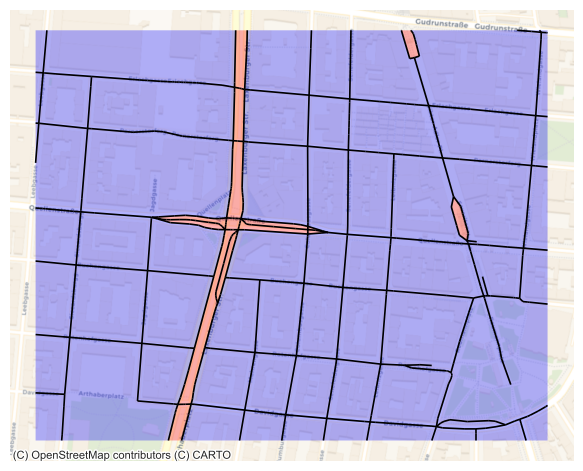

In [140]:
# initialize plot
fig, ax = plt.subplots(1, 1)

# add face artifacts
fua[fua["circular_compactness_index"] <= threshold].plot(ax=ax, alpha=0.3, color="red")

# add true urban blocks
fua[fua["circular_compactness_index"] > threshold].plot(ax=ax, alpha=0.3, color="blue")

# add street edges
edges.plot(ax=ax, color="black")

# add basemap
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Voyager, crs=fua.crs)

# no axis
ax.set_axis_off()

plt.show()

**Possibly supplementary figures?**

Bird-eye view plots

### TO DO: plot in PROJECTED crs

In [ ]:
option = "circular_compactness_index"

for city in all_poly_data.name.unique()[82:83]:
    threshold = results[city][option]["threshold"]

    if threshold:
        # get block data for current city
        fua = all_poly_data[all_poly_data.name == city]

        # initialize figure
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))

        # plot true urban blocks
        fua[fua["circular_compactness_index"] > threshold].plot(
            ax=ax, color="grey", alpha=0.2
        )

        # plot street artifacts
        fua[fua["circular_compactness_index"] <= threshold].plot(
            ax=ax, color="red", alpha=1
        )

        ax.set_xlim()
        ax.set_ylim()
        ax.set_axis_off()

        plt.rc("figure", titlesize=50)
        fig.suptitle(city.capitalize())
        # fig.savefig(f"../plots/cities/birdview/{city}.png", dpi = 300, bbox_inches = "tight")
        print(f"Plotted {city}")
        plt.show()
    else:  # if no threshold has been found
        print(f"No threshold found for {city}")